# Santander Customer Transaction Prediction

*Alexey Pronin*

*February 24, 2019*

## The Brief Description of the Purpose of the Notebook

This Python notebook is created for the [Kaggle Santander Customer Transaction Prediction competition](https://www.kaggle.com/c/santander-customer-transaction-prediction#evaluation). The main objective of the competition is to identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted, using an anonymized dataset containing numeric feature variables, the binary `target` column, and a string `ID_code` column. The dataset is split into training and testing data stored in *train.csv* and *test.csv* files, respectively. The `target` column is included only in the training dataset. To fulfil the main objective of the competition we need to predict the value of `target` column in the test set.

## Exploratory Data Analysis (EDA)

### Reading the Train and Test Data

We begin by reading the *train.csv* and *train.csv* data files and storing their content in two panda data frames, `test` and `train`.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

# Define path to the directory containing the train and test data:
path = Path('../input')

train = pd.read_csv(path /'train.csv', header=0)
test = pd.read_csv(path / 'test.csv', header=0)

### Getting to Know the Data

First of all, let's determine the physical sizes of the train and test datasets (in Mb):

In [2]:
from sys import getsizeof

print("The sizes of the training and testing data are {:.2f} Mb and {:.2f} Mb, respectively."
      .format(getsizeof(train)/(1024**2), getsizeof(test)/(1024**2)))

The sizes of the training and testing data are 319.76 Mb and 318.04 Mb, respectively.


The dimensions of the train and test dataset:

In [3]:
train.shape

(200000, 202)

In [4]:
test.shape

(200000, 201)

We see that both the training and testing datasets contain 200,000 rows. There are 201 features (or variables) that are present in both data sets and one variable that is present only in the training data set (obviously, it must be the `target` variable that we are trying to predict).

Let's take a look at the first few rows of `train`.

In [5]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


Are their any missing values in the data?

In [6]:
train.isna().sum().sum()

0

In [7]:
test.isna().sum().sum()

0

No missing values! What about the data types? Are they well defined?

In [8]:
train.dtypes.value_counts()

float64    200
object       1
int64        1
dtype: int64

This shows that the data type are well defined for all columns of the data set.

### The *ID_code* Column Values

It looks like the *ID_code* variable of `train` follows the same pattern: train_0, train_1, train_2, etc. Is it true for all rows? Let's see:

In [9]:
np.array_equal(np.array(['train_' + str(i) for i in range(0, train.shape[0])]), train['ID_code'])

True

Yes, it is true. What about the *ID_code* column of `test`? 

In [10]:
np.array_equal(np.array(['test_' + str(i) for i in range(0, test.shape[0])]), test['ID_code'])

True

Thus, the *ID_code* column of `test` follows the same pattern: test_0, test_1, test_2, etc.

### The *target* Column

How many zeroes and ones are there in the *target* column?

In [11]:
train_target_counts = train.target.value_counts()
train_target_counts

0    179902
1     20098
Name: target, dtype: int64

In [12]:
ones = train.target.mean()*100
zeroes = 100 - ones

In [13]:
print('Thus, the column contains {:.2f}% of ones and {:.2f}% of zeroes.'.format(ones, zeroes))

Thus, the column contains 10.05% of ones and 89.95% of zeroes.


This shows that the data set is imbalanced. Here is a count plot inllustrating this distribution of values in the *target* column:

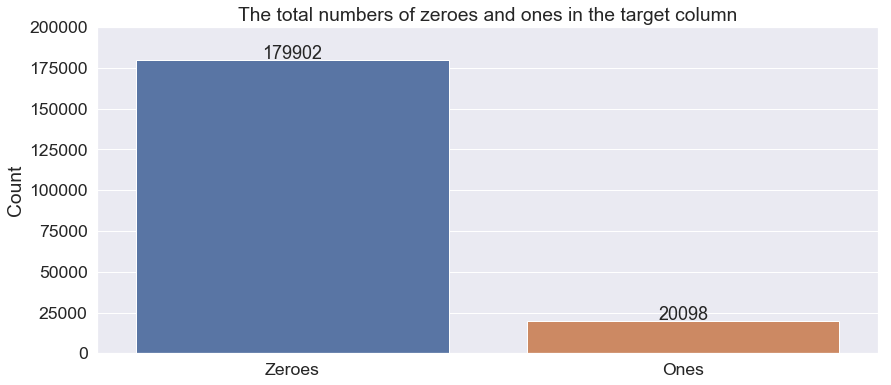

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

width = 14
height = 6
plt.figure(figsize=(width, height))
sns.set(font_scale=1.6)

ax = sns.countplot(x='target', data=train)
ax.set(xlabel='',
       ylabel='Count', 
       title= 'The total numbers of zeroes and ones in the target column', ylim=(0, 200000), 
       xticklabels=['Zeroes', 'Ones'])

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 350,
            '{:1.0f}'.format(height), fontsize=18,
            ha="center") 

plt.show()

### The Statistical Summaries of the Numeric Feature Variables

The data set also contains 200 numeric feature variables, *var_0* to *var_199*. We are not given any information about the meaning of these variables, so let's take a little bit closer look at them. 

First of all, it looks like the column names of the numeric features follow the same pattern: *var_0, var_1, var_2,* etc. Let's make sure that this pattern does not break at some point:

In [15]:
features = np.array(['var_' + str(i) for i in range(0, 200)])
np.array_equal(features, train.columns[2:])

True

In [16]:
np.array_equal(features, test.columns[1:])

True

No, the pattern is consistent throughout all numerical columns. 

Now, let's take a look at the summary statistics for these columns:

In [17]:
data_description_train = train.describe()
data_description_train

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [18]:
data_description_test = test.describe()
data_description_test

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400


To make it easier to see what is going on let's make a histogram for the maximum and minimum values, their difference, and the standard deviation.

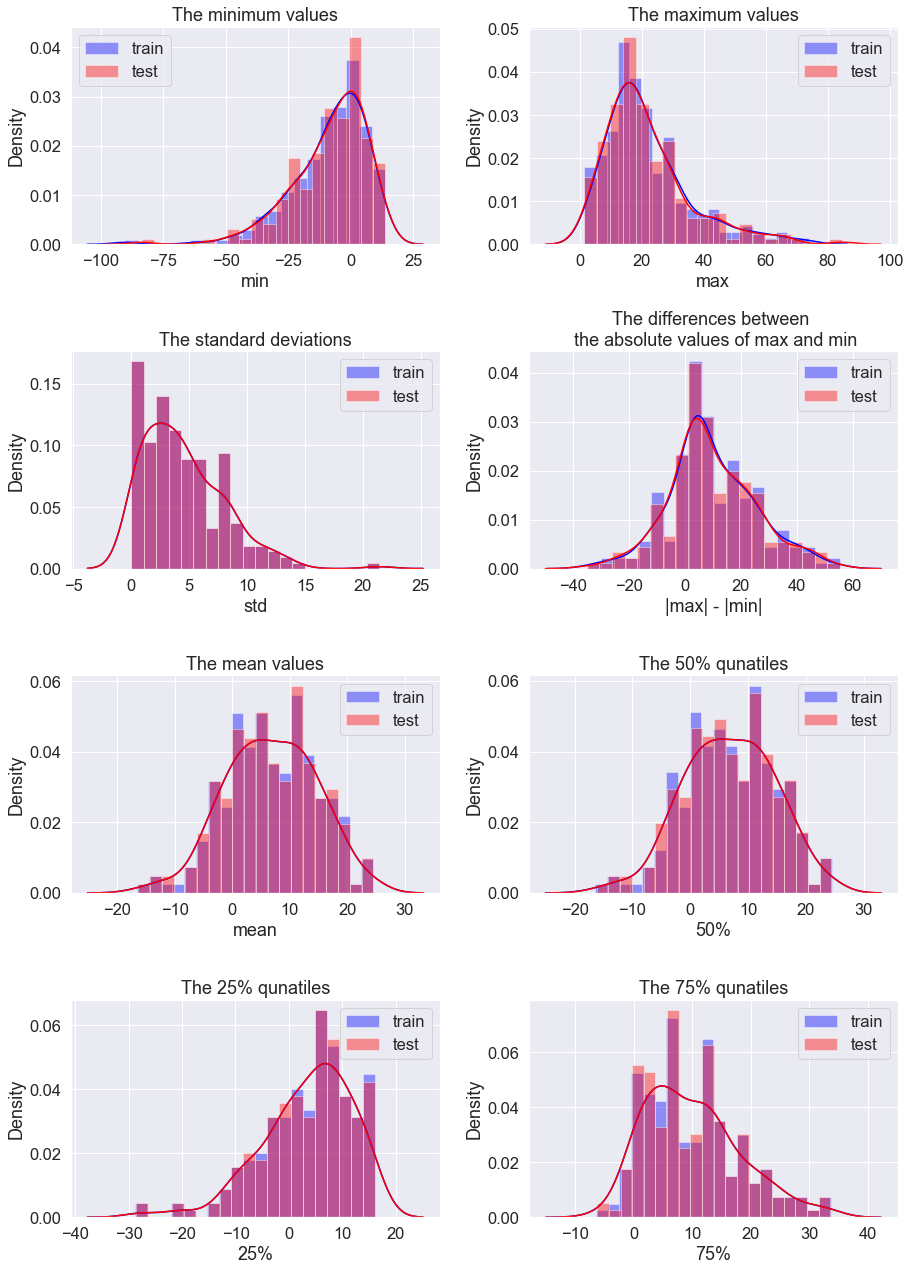

In [19]:
width = 13
height = 18
plt.figure(figsize=(width, height))

sns.set(font_scale=1.5)

col_train = 'blue'
col_test = 'red'

plt.subplot(4, 2, 1)
sns.distplot(data_description_train.loc['min', 'var_0':], bins=20, color=col_train, label='train')
sns.distplot(data_description_test.loc['min', :], bins=20, color=col_test, label='test')
plt.title('The minimum values')
plt.ylabel('Density')
plt.legend()

plt.subplot(4, 2, 2)
sns.distplot(data_description_train.loc['max', 'var_0':], bins=20, color=col_train, label='train')
sns.distplot(data_description_test.loc['max', :], bins=20, color=col_test, label='test')
plt.title('The maximum values')
plt.ylabel('Density')
plt.legend()

plt.subplot(4, 2, 3)
sns.distplot(data_description_train.loc['std', 'var_0':], bins=20, color=col_train, label='train')
sns.distplot(data_description_test.loc['std', :], bins=20, color=col_test, label='test')
plt.title('The standard deviations')
plt.ylabel('Density')
plt.legend()

plt.subplot(4, 2, 4)
sns.distplot((np.absolute(data_description_train.loc['max', 'var_0':]) - 
              np.absolute(data_description_train.loc['min', 'var_0':])), 
              bins=20, color=col_train, label='train')

sns.distplot((np.absolute(data_description_test.loc['max', 'var_0':]) - 
              np.absolute(data_description_test.loc['min', 'var_0':])), 
              bins=20, color=col_test, label='test')

plt.title('The differences between \n the absolute values of max and min')
plt.ylabel('Density')
plt.xlabel('|max| - |min|')
plt.legend()

plt.subplot(4, 2, 5)
sns.distplot(data_description_train.loc['mean', 'var_0':], bins=20, color=col_train, label='train')
sns.distplot(data_description_test.loc['mean', :], bins=20, color=col_test, label='test')
plt.title('The mean values')
plt.ylabel('Density')
plt.legend()

plt.subplot(4, 2, 6)
sns.distplot(data_description_train.loc['50%', 'var_0':], bins=20, color=col_train, label='train')
sns.distplot(data_description_test.loc['50%', :], bins=20, color=col_test, label='test')
plt.title('The 50% qunatiles')
plt.ylabel('Density')
plt.legend()

plt.subplot(4, 2, 7)
sns.distplot(data_description_train.loc['25%', 'var_0':], bins=20, color=col_train, label='train')
sns.distplot(data_description_test.loc['25%', :], bins=20, color=col_test, label='test')
plt.title('The 25% qunatiles')
plt.ylabel('Density')
plt.legend()

plt.subplot(4, 2, 8)
sns.distplot(data_description_train.loc['75%', 'var_0':], bins=20, color=col_train, label='train')
sns.distplot(data_description_test.loc['75%', :], bins=20, color=col_test, label='test')
plt.title('The 75% qunatiles')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()

We see that the training and test data have very similar distributions of the numeric variables. In some cases, they look identical! For instance, look at the standard deviation graph -- you do not see the training data graph at all because they are covered by the test data graph (you can also check out the summary tables above showing the standard deviations for both `train` and `test`). Also, observe that there is not much diversity in the numerical values of these statistical parameters of the data -- all of them have their typical values within 20-60 units away from the origin. Interesting... Is this data set synthetic? 

### The Distributions of Values in the Numerical Columns

After inspecting the summary statistics, let's turn our attention to individual columns. There are a lot of them, so it would be nice to be able to see the plots showing the distribution of values in these columns -- also, we would like to see whether or not these distributions are the same for the two classes of the *target* column. 

<Figure size 432x288 with 0 Axes>

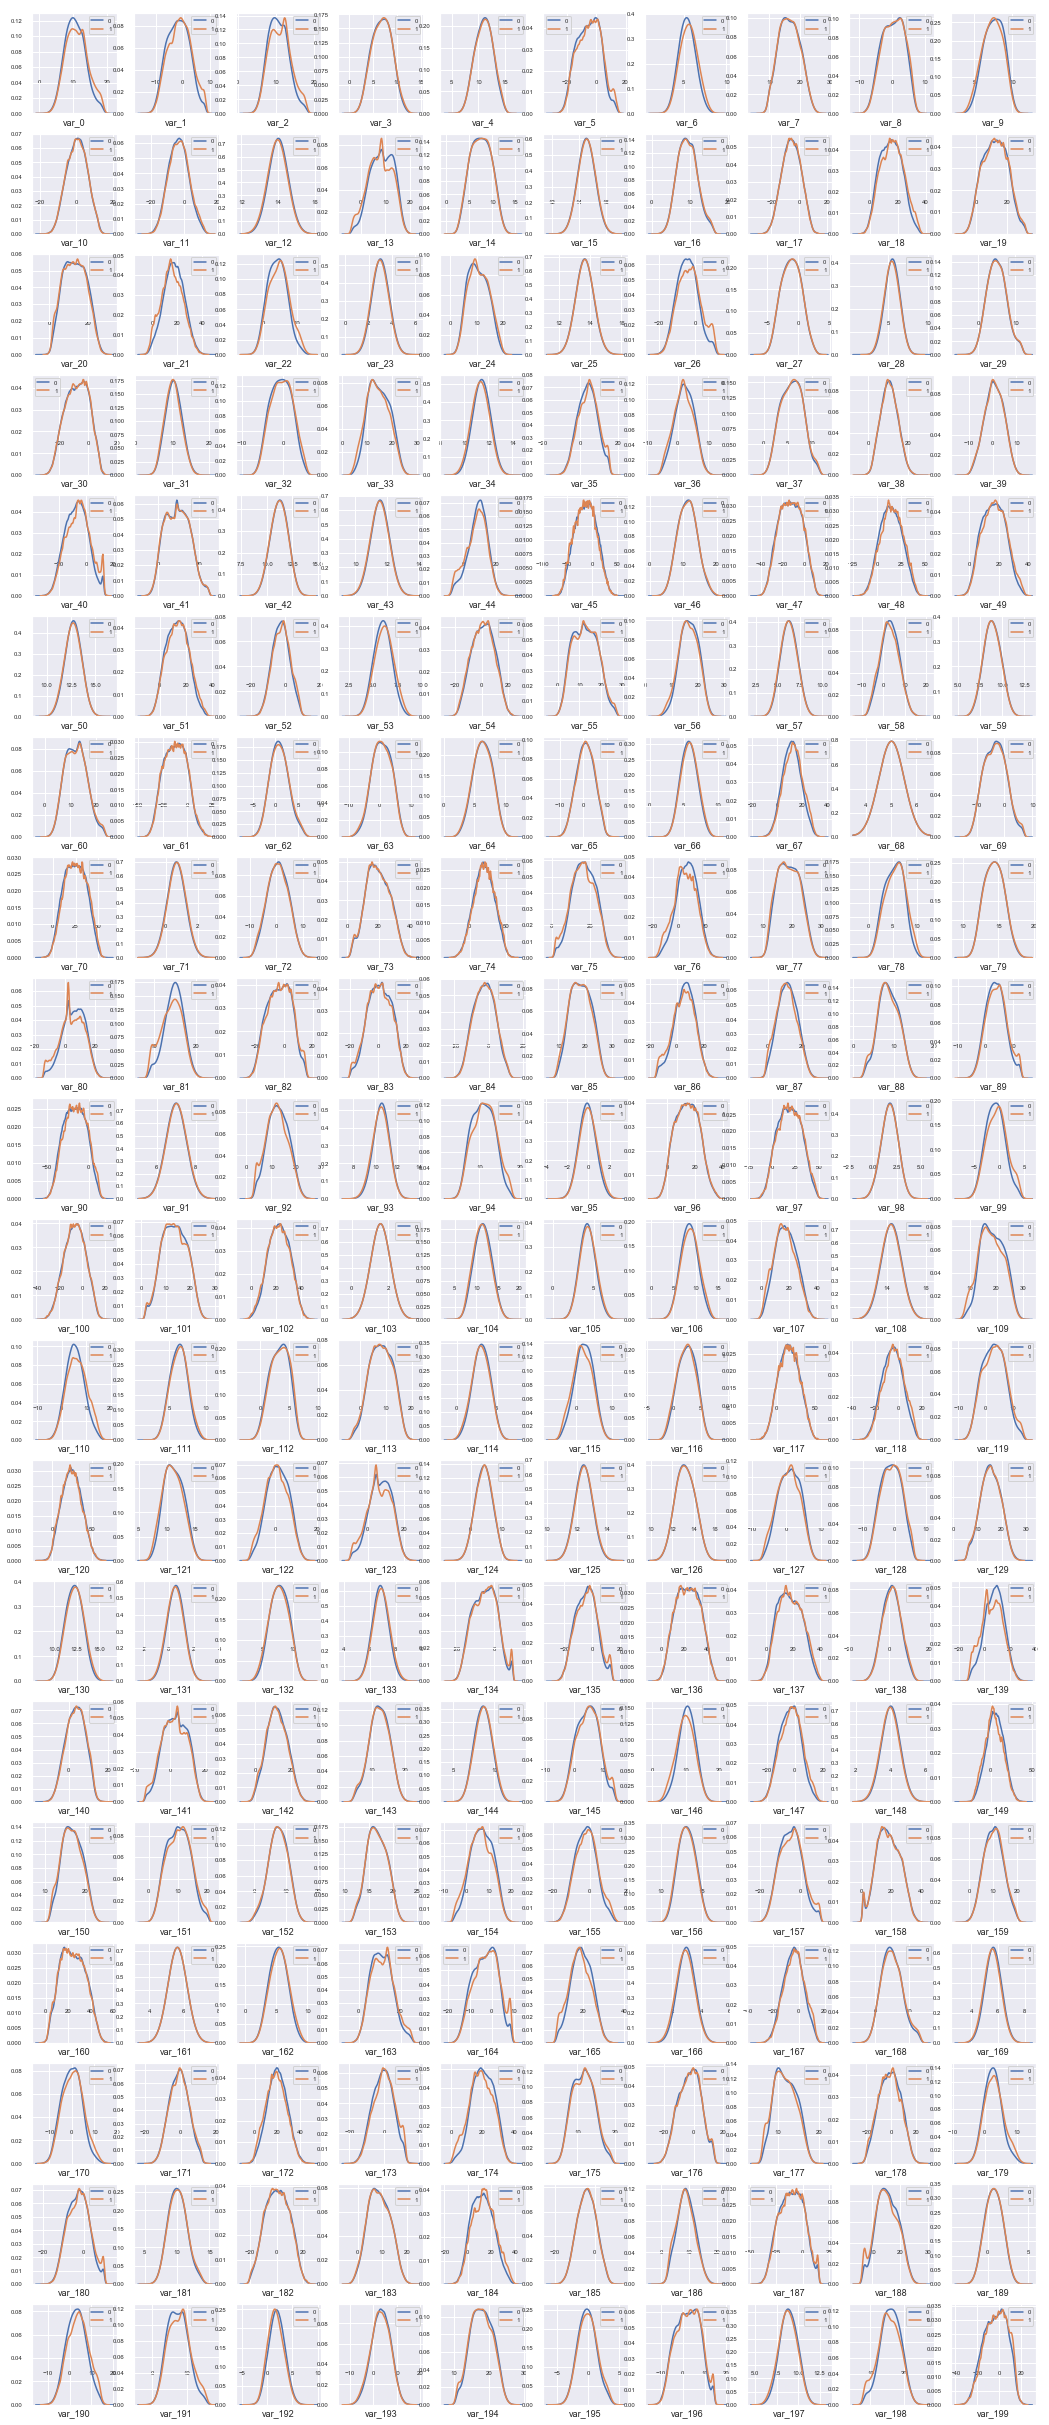

In [20]:
vsize = 20
plt.figure()
fig, ax = plt.subplots(vsize,10,figsize=(18,44))


for (i, feature) in enumerate(features[0:vsize*10]):
    i += 1
    plt.subplot(vsize,10,i)
    sns.kdeplot(train.loc[train['target'] == 0, feature], bw=0.5,label='0')
    sns.kdeplot(train.loc[train['target'] == 1, feature], bw=0.5,label='1')
    plt.xlabel(feature, fontsize=9)
    locs, labels = plt.xticks()
    plt.tick_params(axis='x', which='major', labelsize=6, pad=-40)
    plt.tick_params(axis='y', which='major', labelsize=6)
    plt.legend(loc='best', fontsize='6')
    
plt.show()

We see that not all variable have the same distributions for `target=0` and `target=1`: *var_81* or *var_110* would be two good examples illustrating this point. I beleive that this observation might become important later when we will be doing feature engineering.

### Correlations among the Numerical Features

Let's take a look at correlations.

In [21]:
correlations = train[1:].corr()

The correlations between the numerical features and the `target` variable (in the descending order):

In [22]:
correlations.target.sort_values(ascending=False).head(10)

target     1.000000
var_6      0.066730
var_110    0.064274
var_53     0.063397
var_26     0.062422
var_22     0.060557
var_99     0.058365
var_190    0.055974
var_2      0.055871
var_133    0.054547
Name: target, dtype: float64

In [23]:
correlations.target.sort_values(ascending=False).tail(10)

var_165   -0.055736
var_80    -0.057608
var_166   -0.057774
var_21    -0.058483
var_174   -0.061669
var_76    -0.061919
var_146   -0.063643
var_12    -0.069489
var_139   -0.074078
var_81    -0.080918
Name: target, dtype: float64

The strongest negative correlation we observe is with *var_81* and it is just a bit higher than eight percent. The strongest positive correlation is with *var_6* and it is just above 6.6 percent. Thus we see that correlations are quite weak!

What correlations are the weakest? To find out, let's compute the absolute values of the correlations and sort them in the ascending order:

In [24]:
correlations.target.abs().sort_values().head(10)

var_185    0.000057
var_27     0.000581
var_30     0.000639
var_17     0.000863
var_38     0.000967
var_41     0.001298
var_126    0.001394
var_103    0.001397
var_10     0.002212
var_100    0.002218
Name: target, dtype: float64

What about the correlations of the numerical features among themselves? There are a lot of them -- let's plot the correlation matrix to inspect them visually:

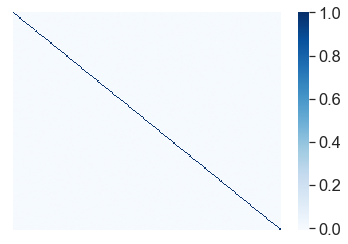

In [25]:
sns.heatmap(correlations.iloc[1:, 1:], xticklabels=False, yticklabels=False, cmap='Blues')

The heatmap plot above suggests that the correlations are quite small! To make sure that this is indeed the case, we will compute the strongest positive and the strongest negative correlations. To do that, we will first need to extract the upper triangular part of the correlation matrix for the numercial features (recall that the matrix is symmetric and we are not interested in the diagonal entries which are all ones). To do this extraction we can use a handy numpy `np.triu_indices()` function that returns the indicies for the upper-triangular part of a numpy matrix. To remove the diagonal elements we will need to set the optional argument `k` to one.

In [26]:
n_corr = correlations.iloc[1:, 1:].shape[0]
n_corr

200

In [27]:
upper_triangular_indx = np.triu_indices(n_corr, k=1)
upper_triangular_indx

(array([  0,   0,   0, ..., 197, 197, 198]),
 array([  1,   2,   3, ..., 198, 199, 199]))

In [28]:
np.array(correlations.iloc[1:, 1:])[upper_triangular_indx].max()

0.009711166101487936

In [29]:
np.array(correlations.iloc[1:, 1:])[upper_triangular_indx].min()

-0.009843439201036296

Both positive and negative correlations are weaker than one percent! The numerical features seem to be fairly independent of each other.

## Modeling

Okay, let's do some modeling! But first we need to turn our data into `numpy` arrays because this is what works best with *scikit-learn* which we will be using very extensively. 

In [30]:
X_train = train.iloc[:, 2:].values.astype('float')
y_train = train.target.values

### Logistic Regression

Let's begin our model building with logistic regression.

0.8612830316184605

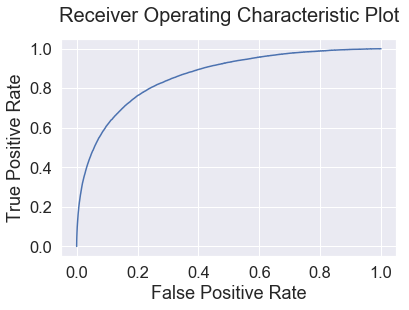

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc

pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr_clf', LogisticRegression(solver='lbfgs'))
])

pipe_lr.fit(X_train, y_train)

title_config = {'fontsize': 20, 'y': 1.05}
fpr, tpr, thr = roc_curve(y_train, pipe_lr.predict_proba(X_train)[:,1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Plot', **title_config)
auc(fpr, tpr)

In [32]:
from sklearn.model_selection import cross_val_score

cv_lr = cross_val_score(pipe_lr, X_train, y_train, scoring='roc_auc', cv=5)
cv_lr.mean()

0.8594815338307955

In [33]:
cv_lr.std()

0.003474592654703778

### Elastic Net

It looks like logistic regression is working reasonably well. The AUC we are getting is about 86 percent. This is not bad at all! Is it possible to improve this result even further by enhancing the logistic regression algorithm? To this end, let's try the elastic net classifier (which goes by the name *Stochastic Gradient Decent* in *scikit-learn*).

In the code below:

* `loss='log'` gives logistic regression;
* `alpha ` is  the penalty strength parameter;
* `l1_ratio` is the ratio between $l_1$ and $l_2$ penalties, ranging from 0 (ridge) to 1 (lasso).

0.8612404574944004

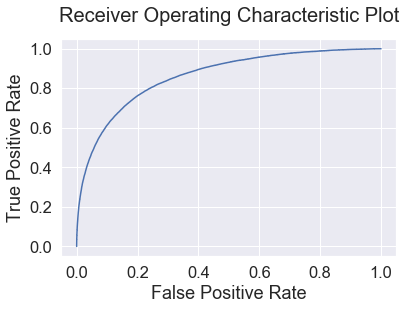

In [34]:
from sklearn.linear_model import SGDClassifier

pipe_sgd = Pipeline([
    ('scaler', StandardScaler()),
    ('sgd_clf', SGDClassifier(loss='log', penalty='elasticnet', random_state=42,
                                        alpha=0.02, l1_ratio=0, max_iter=1000, tol=1e-3))
])

pipe_sgd.fit(X_train, y_train)

fpr, tpr, thr = roc_curve(y_train, pipe_sgd.predict_proba(X_train)[:,1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Plot', **title_config)
auc(fpr, tpr)

In [35]:
cv_sgd = cross_val_score(pipe_sgd, X_train, y_train, scoring='roc_auc', cv=5)
cv_sgd.mean()

0.8595775923053584

In [36]:
cv_sgd.std()

0.003483330585771889

It looks like the ridge regression (`l1_ratio=0`) presented above gives pretty much the same result as the logistic regression that we did earlier. I also tried *lasso* (`l1_ratio=1`) but the performance was significantly worse.

### Gaussian Naive Bayes

0.8899668718586371

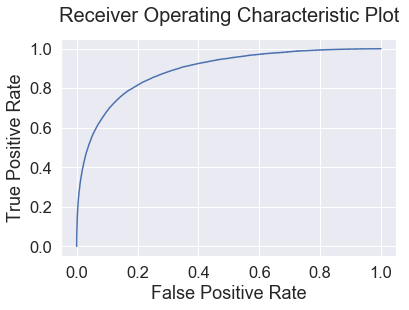

In [37]:
from sklearn.naive_bayes import GaussianNB

pipe_gnb = Pipeline([
    ('scaler', StandardScaler()),
    ('gnb_clf', GaussianNB())
])

pipe_gnb.fit(X_train, y_train)

fpr, tpr, thr = roc_curve(y_train, pipe_gnb.predict_proba(X_train)[:,1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Plot', **title_config)
auc(fpr, tpr)

In [38]:
cv_gnb = cross_val_score(pipe_gnb, X_train, y_train, scoring='roc_auc', cv=5)
cv_gnb.mean()

0.8883828469044662

In [39]:
cv_gnb.std()

0.002839192421515221

This is an improvement! The cross-validation (CV) score has gone up by almost 3% and the CV standard deviation has gone down by about 0.00065. Not bad at all!

### Linear Discriminant Analysis (LDA)

Now let's try LDA.

0.8611443112858344

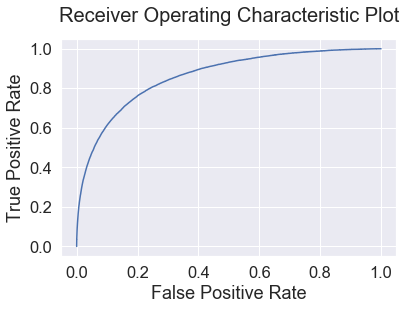

In [40]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

pipe_lda = Pipeline([
    ('scaler', StandardScaler()),
    ('gnb_clf', LinearDiscriminantAnalysis())
])

pipe_lda.fit(X_train, y_train)

fpr, tpr, thr = roc_curve(y_train, pipe_lda.predict_proba(X_train)[:,1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Plot', **title_config)
auc(fpr, tpr)

In [41]:
cv_lda = cross_val_score(pipe_lda, X_train, y_train, scoring='roc_auc', cv=5)
cv_lda.mean()

0.8595662555613863

In [42]:
cv_lda.std()

0.0034969051423469322

The performance of LDA is about the same as that of logistic regression.

### Quadratic Discriminant Analysis (QDA)

Now let's try QDA.

0.9230415664249059

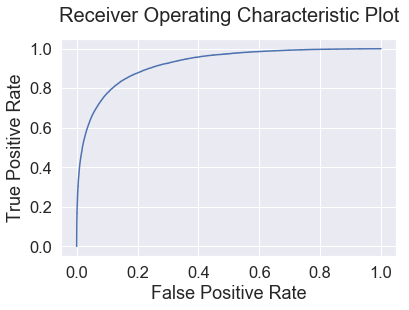

In [43]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
pipe_qda = Pipeline([
    ('scaler', StandardScaler()),
    ('gnb_clf', QuadraticDiscriminantAnalysis())
])

pipe_qda.fit(X_train, y_train)

fpr, tpr, thr = roc_curve(y_train, pipe_qda.predict_proba(X_train)[:,1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Plot', **title_config)
auc(fpr, tpr)

The training AUC looks really good? But is this result true?

In [44]:
cv_qda = cross_val_score(pipe_qda, X_train, y_train, scoring='roc_auc', cv=5)
cv_qda.mean()

0.8426382867182559

In [45]:
cv_qda.std()

0.002466204880351138

The cross-validation AUC is actually worse than that of logistic regression, so QDA is clearly overfitting the data.

### Correlations among the Models

For the purpose of further analysis, let's compute the correlations among the predictions of these models on the test data:

In [46]:
X_test = test.iloc[:, 1:]
pd.DataFrame({'lr'  : pipe_lr.predict_proba(X_test)[:,1],
              'sgd' : pipe_sgd.predict_proba(X_test)[:,1],
              'gnb'  : pipe_gnb.predict_proba(X_test)[:,1],
              'lda' : pipe_lda.predict_proba(X_test)[:,1],
              'qda' : pipe_lda.predict_proba(X_test)[:,1]
             }).corr()

,lr,sgd,gnb,lda,qda
lr,1.000000,0.996636,0.899490,0.999537,0.999537
sgd,0.996636,1.000000,0.896348,0.995886,0.995886
gnb,0.899490,0.896348,1.000000,0.900399,0.900399
lda,0.999537,0.995886,0.900399,1.000000,1.000000
qda,0.999537,0.995886,0.900399,1.000000,1.000000


As side note, let me mention that alternatively, we could have computed the correlations using the `pearsonr` function from `scipy.stats`. For example, the correlation between the Gaussian Naive Bayes (`gnb`) and logistic regression (`lr`) models is

In [47]:
from scipy.stats import pearsonr

a = pipe_lr.predict_proba(X_test)[:,1]
b = pipe_gnb.predict_proba(X_test)[:,1]

pearsonr(a, b)[0]

0.8994900041184986

which matches the corresponding result from the table given above.

### Soft Voting Classifier

Now, let's build a soft voting classifier using all of the models.

In [49]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[
    ('lr', pipe_lr), 
    ('sgd', pipe_sgd), 
    ('gnb', pipe_gnb), 
    ('lda', pipe_lda), 
    ('qda', pipe_qda)
], voting='soft', weights=[7, 7, 30, 3, 1])

voting_clf.fit(X_train, y_train)

cv_voting_clf = cross_val_score(voting_clf, X_train, y_train, scoring='roc_auc', cv=5)
cv_voting_clf.mean()

0.8840039332496227

In [50]:
cv_voting_clf.std()

0.0030238377809469518

This does not look like an improvement comparing to the Naive Bayes result.

### Confusion matricies

To complete this preliminary analysis, let's compute and plot confusion matricies for all of these classifiers. Frist, we will define a function for plotting a confusion matrix:

In [75]:
def plot_cofusion_matrix(cm, clf_name='Model'):
    plt.figure(figsize=(7,6))

    sns.heatmap(cm, cmap='Blues', annot=True, fmt='d')
    plt.ylabel('True values')
    plt.xlabel('Predicted values')
    plt.title('Confusion matrix: '+clf_name)

    plt.tight_layout()

The confusion matrix for the logistic regression:

In [66]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(pipe_lr, X_train, y_train, cv=5)

cm_lr=confusion_matrix(y_train, y_train_pred)

cm_lr

array([[177415,   2487],
       [ 14649,   5449]])

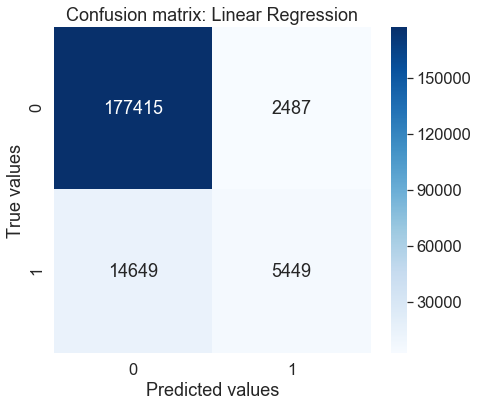

In [76]:
plot_cofusion_matrix(cm_lr, 'Linear Regression')

The elastic net confusion matrix:

In [68]:
y_train_pred = cross_val_predict(pipe_sgd, X_train, y_train, cv=5)

cm_sgd=confusion_matrix(y_train, y_train_pred)
cm_sgd

array([[178906,    996],
       [ 16592,   3506]])

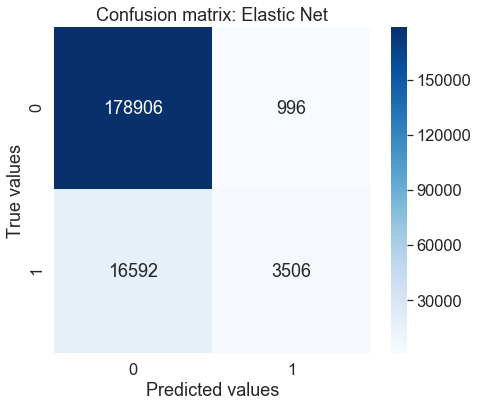

In [77]:
plot_cofusion_matrix(cm_sgd, 'Elastic Net')

The Gaussian Naive Bayes confusion matrix:

In [70]:
y_train_pred = cross_val_predict(pipe_gnb, X_train, y_train, cv=5)

cm_gnb=confusion_matrix(y_train, y_train_pred)
cm_gnb

array([[176987,   2915],
       [ 12795,   7303]])

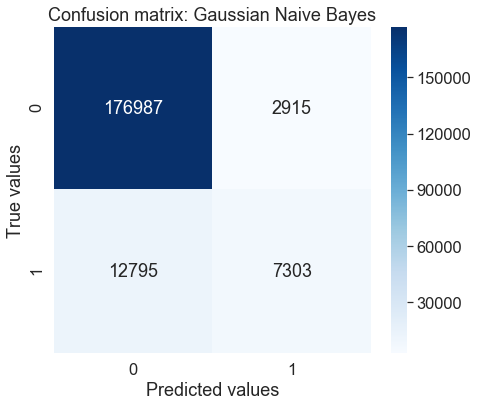

In [78]:
plot_cofusion_matrix(cm_gnb, 'Gaussian Naive Bayes')

The LDA confusion matrix:

In [72]:
y_train_pred = cross_val_predict(pipe_lda, X_train, y_train, cv=5)

cm_lda=confusion_matrix(y_train, y_train_pred)
cm_lda

array([[177264,   2638],
       [ 14518,   5580]])

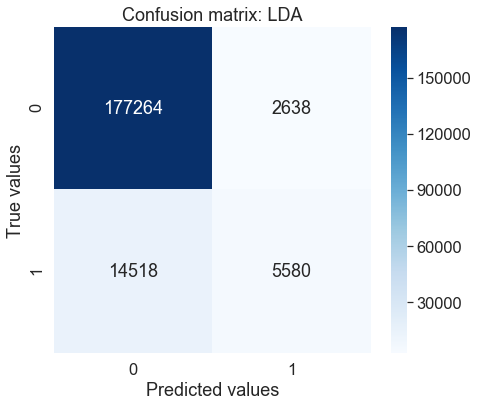

In [79]:
plot_cofusion_matrix(cm_lda, 'LDA')

The QDA confusion matrix:

In [74]:
y_train_pred = cross_val_predict(pipe_qda, X_train, y_train, cv=5)

cm_qda=confusion_matrix(y_train, y_train_pred)
cm_qda

array([[176153,   3749],
       [ 14162,   5936]])

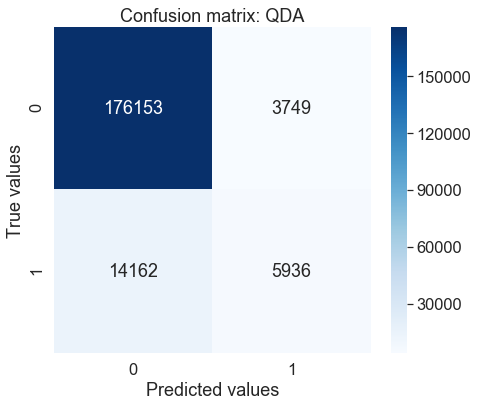

In [80]:
plot_cofusion_matrix(cm_qda, 'QDA')

Observe that all of the classifiers contain a very large number of false negatives shown in the lower left quadrants of the confusion matrices. It means that the classifiers are having a hard time identifying the instances that belong to the positive class (`target=1`). Most of such instances are misclassified as negtatives (`target=0`). It should not look very surpising because the positive class is underrepresented in this imbalanced data set. This suggests that applying some kind of technique alleviating this class imbalance (e.g. upsamling the positive class or downsampling the negative one) might be very helpful here.